## Word2Vec Approach

In [556]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, \
    nltk, collections, keras, lightgbm as lgb
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
#from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import re,string,unicodedata
from string import punctuation
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from keras import layers
import keras_tuner

from keras.layers import Bidirectional, LSTM, GRU
import gensim
from gensim.models import Word2Vec


In [557]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rusconbenito@edu.local/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing

In [558]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
#article URLs not needed
df.drop(columns=['article_link'], inplace=True)

#remove Stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [559]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [560]:
#kudos https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy#LOADING-THE-DATASET
#remove square brackets, URLs and Noise

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing numbers as it can cause additional noise
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

#Removing the noisy text 
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [561]:
#converting text to format acceptable by gensim

words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

## Word2Vec Model

In [562]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words, window = 5, min_count = 1)
w2v_model.wv.vectors.shape


(37056, 100)

In [563]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
#tokenized_train = tokenizer.texts_to_sequences(words)
#x = sequence.pad_sequences(tokenized_train, maxlen = 20)
sequences = tokenizer.texts_to_sequences(words)
#help from CHTGPT
padded_sequences = pad_sequences(sequences, maxlen=20)
vocab_size = len(tokenizer.word_index) + 1

In [564]:
padded_sequences

array([[    0,     0,     0, ...,  2318,   555,   934],
       [    0,     0,     0, ..., 11257,  1977,  1796],
       [    0,     0,     0, ..., 16465,   475,  1346],
       ...,
       [    0,     0,     0, ...,   946,   665,  1639],
       [    0,     0,     0, ...,  2978,   815,  5899],
       [    0,     0,     0, ...,  2947,   171,    89]], dtype=int32)

In [565]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [566]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

### Training Word2Vec model

In [567]:
#tuner model for optimal hyperparameters

from keras.layers import Bidirectional, LSTM, GRU

def build_model(hp):

    model = keras.Sequential()

    model.add(layers.Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], input_length=20, trainable=True))

    #tune the number of layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            Bidirectional(LSTM(
                #tune number of nodes separately
                units=hp.Int(f"units_{i}", min_value=4, max_value=64, step=2),
                #tune recurrent dropout
                recurrent_dropout=hp.Float(f"recurrent_dropout_{i}", min_value=0.0, max_value=0.5, step=0.1),
                #tune dropout
                dropout=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.5, step=0.1),
                return_sequences=True,
                name=f"bidirectional_LSTM_{i}"
                )
            )
        )
        model.add(
            Bidirectional(GRU(
                #tune number of nodes separately
                units=hp.Int(f"units_{i}", min_value=8, max_value=64, step=2),
                #tune recurrent dropout
                recurrent_dropout=hp.Float(f"recurrent_dropout_{i}", min_value=0.0, max_value=0.5, step=0.1),
                #tune dropout
                dropout=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.5, step=0.1),
                name=f"bidirectional_GRU_{i}"
                )
            )
        )
        #tune learning rate
        learning_rate_tuned = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    #last Layer, use sigmoid activation function
    model.add(layers.Dense(1, activation="sigmoid", name="output"))

    #compile the model, use binary_crossentropy loss function as we have a binary classification problem
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate_tuned),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [568]:
build_model(keras_tuner.HyperParameters())

2023-03-30 15:01:14.657835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 15:01:14.659817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 15:01:14.661805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [569]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    #The total number of trials to run during the search.
    max_trials=10,
    
    #The number of models that should be built and fit for each trial.
    #The purpose of having multiple executions per trial is to reduce results variance and
    #therefore be able to more accurately assess the performance of a model
    executions_per_trial=2,
    overwrite=True,
    directory="tuner_sarcasm_detection",
    project_name="Sarcasm_Detection",
)

tuner.search_space_summary()

2023-03-30 15:01:15.780091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 15:01:15.782610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 15:01:15.784251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 2, 'sampling': 'linear'}
recurrent_dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


2023-03-30 15:01:16.524062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 15:01:16.526511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 15:01:16.528141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [570]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df.is_sarcastic , test_size = 0.2 , random_state = 187) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25 , random_state = 187)

In [572]:
#needs to be run on HPC
tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Trial 7 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.8076519966125488
Total elapsed time: 00h 42m 40s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
3                 |1                 |num_layers
8                 |28                |units_0
0.1               |0.1               |recurrent_dropout_0
0                 |0.3               |dropout_0
0.0010264         |0.0032434         |lr
64                |22                |units_1
0.3               |0.4               |recurrent_dropout_1
0.2               |0.4               |dropout_1



Traceback (most recent call last):
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
 

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_88143/3532007676.py", line 13, in build_model
    model.add(
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/tensorflow/python/trackable/base.py", line 205, in _method_wrapper
    result = method(self, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/keras/engine/input_spec.py", line 235, in assert_input_compatibility
    raise ValueError(
ValueError: Input 0 of layer "bidirectional_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 16)


In [ ]:

tuner.results_summary()
#get the best models
best_model = tuner.get_best_models(num_models=1)[0]
#build the best model
best_model.build(X_train.shape)
#summary of the best model
best_model.summary()
#show the best hyperparameters
tuner.get_best_hyperparameters(num_trials=1)[0].values


'\ntuner.results_summary()\n#get the best models\nbest_model = tuner.get_best_models(num_models=1)[0]\n#build the best model\nbest_model.build(X_train.shape)\n#summary of the best model\nbest_model.summary()\n#show the best hyperparameters\ntuner.get_best_hyperparameters(num_trials=1)[0].values\n'

In [ ]:

#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
#Output layer
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 20, 100)           3705700   
                                                                 
 bidirectional_18 (Bidirecti  (None, 20, 256)          234496    
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 64)               55680     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,995,941
Trainable params: 3,995,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto')

history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_val,y_val) , epochs = 1000, callbacks=[early_stopping])

Epoch 1/1000
135/135 [==============================] - 22s 96ms/step - loss: 0.6801 - acc: 0.5734 - val_loss: 0.6739 - val_acc: 0.5760
Epoch 2/1000
135/135 [==============================] - 12s 86ms/step - loss: 0.6562 - acc: 0.6053 - val_loss: 0.6309 - val_acc: 0.6405
Epoch 3/1000
135/135 [==============================] - 12s 87ms/step - loss: 0.5465 - acc: 0.7221 - val_loss: 0.4969 - val_acc: 0.7587
Epoch 4/1000
135/135 [==============================] - 12s 92ms/step - loss: 0.3829 - acc: 0.8388 - val_loss: 0.5063 - val_acc: 0.7633
Epoch 5/1000
135/135 [==============================] - 12s 86ms/step - loss: 0.2832 - acc: 0.8859 - val_loss: 0.4417 - val_acc: 0.7977
Epoch 6/1000
135/135 [==============================] - 12s 87ms/step - loss: 0.2149 - acc: 0.9173 - val_loss: 0.4790 - val_acc: 0.7926
Epoch 7/1000
135/135 [==============================] - 12s 91ms/step - loss: 0.1709 - acc: 0.9358 - val_loss: 0.4766 - val_acc: 0.8010
Epoch 8/1000
135/135 [==========================

KeyboardInterrupt: 

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_val,y_val)[1]*100)

537/537 [==============================] - 9s 17ms/step - loss: 2.7578e-04 - acc: 0.9999
Accuracy of the model on Training Data is -  99.99417662620544
179/179 [==============================] - 3s 16ms/step - loss: 2.3575 - acc: 0.7727
Accuracy of the model on Testing Data is -  77.27113962173462


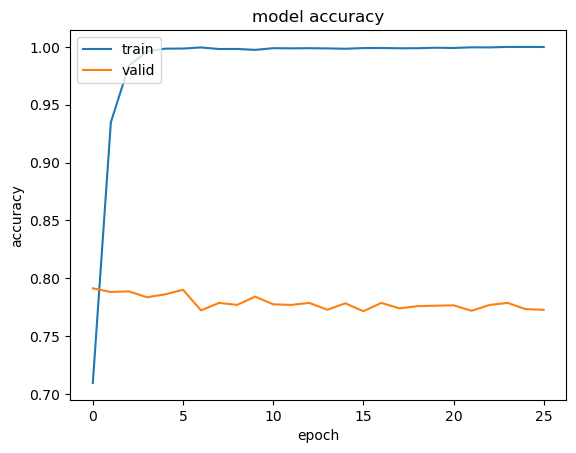

In [ ]:
#plot accuracy and loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
